In [2]:
import pandas as pd
import numpy as np

data = pd.read_csv("../../data/ner_dataset.csv", encoding="latin1")

In [3]:
data = data.fillna(method="ffill")
data.tail(10)

,Sentence #,Word,POS,Tag
1048565,Sentence: 47958,impact,NN,O
1048566,Sentence: 47958,.,.,O
1048567,Sentence: 47959,Indian,JJ,B-gpe
1048568,Sentence: 47959,forces,NNS,O
1048569,Sentence: 47959,said,VBD,O
1048570,Sentence: 47959,they,PRP,O
1048571,Sentence: 47959,responded,VBD,O
1048572,Sentence: 47959,to,TO,O
1048573,Sentence: 47959,the,DT,O
1048574,Sentence: 47959,attack,NN,O


In [4]:
words = list(set(data["Word"].values))
words.append("ENDPAD")

In [5]:
n_words = len(words); n_words

35179

In [6]:
tags = list(set(data["Tag"].values))
n_tags = len(tags); n_tags

17

In [7]:
tags

['I-tim',
 'B-org',
 'O',
 'I-art',
 'I-eve',
 'B-geo',
 'B-gpe',
 'I-geo',
 'B-tim',
 'I-nat',
 'B-per',
 'B-art',
 'I-org',
 'B-nat',
 'I-gpe',
 'I-per',
 'B-eve']

In [8]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data 
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
        
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s 
        except:
            return None

In [9]:
getter = SentenceGetter(data)

In [12]:
sent = getter.get_next()

In [13]:
print(sent)

[('Families', 'NNS', 'O'), ('of', 'IN', 'O'), ('soldiers', 'NNS', 'O'), ('killed', 'VBN', 'O'), ('in', 'IN', 'O'), ('the', 'DT', 'O'), ('conflict', 'NN', 'O'), ('joined', 'VBD', 'O'), ('the', 'DT', 'O'), ('protesters', 'NNS', 'O'), ('who', 'WP', 'O'), ('carried', 'VBD', 'O'), ('banners', 'NNS', 'O'), ('with', 'IN', 'O'), ('such', 'JJ', 'O'), ('slogans', 'NNS', 'O'), ('as', 'IN', 'O'), ('"', '``', 'O'), ('Bush', 'NNP', 'B-per'), ('Number', 'NN', 'O'), ('One', 'CD', 'O'), ('Terrorist', 'NN', 'O'), ('"', '``', 'O'), ('and', 'CC', 'O'), ('"', '``', 'O'), ('Stop', 'VB', 'O'), ('the', 'DT', 'O'), ('Bombings', 'NNS', 'O'), ('.', '.', 'O'), ('"', '``', 'O')]


In [14]:
sentences = getter.sentences

In [15]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")

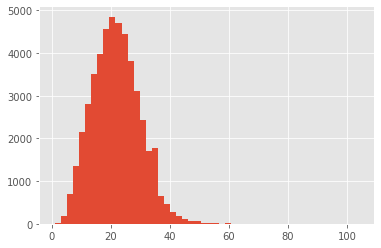

In [16]:
plt.hist([len(s) for s in sentences], bins=50) #bins: 몇개의 바구니로 구분할까
plt.show()

In [19]:
# So we are going to pad our sentences to a length of 50.
max_len = 50
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [21]:
word2idx["Obama"]

19576

In [22]:
tag2idx["B-geo"]

5

In [60]:
# Now we map the sentences to a sequence of numbers and then pad the sequence
from keras.preprocessing.sequence import pad_sequences
X = [[word2idx[w[0]] for w in s] for s in sentences] # data["Word"]

In [61]:
X = pad_sequences(maxlen=max_len, sequences=X, padding='post', value=n_words-1) #padding value = 35178

In [62]:
X[1]

array([34486, 15416, 12112,  6616,  5650, 25845, 27319, 34948, 25845,
       30813, 22668, 31811,  4722,  3925, 21155,  8933,  3472, 33594,
        2549,  3557, 28476,  6829, 13891, 20579,  8755, 35178, 35178,
       35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178,
       35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178,
       35178, 35178, 35178, 35178, 35178], dtype=int32)

In [69]:
y = [[tag2idx[w[2]] for w in s] for s in sentences]

In [70]:
y[0]

[2, 2, 2, 2, 2, 2, 5, 2, 2, 2, 2, 2, 5, 2, 2, 2, 2, 2, 6, 2, 2, 2, 2, 2]

In [71]:
y = pad_sequences(maxlen=max_len, sequences=y, padding='post', value=tag2idx["O"])

In [72]:
y[0]

array([2, 2, 2, 2, 2, 2, 5, 2, 2, 2, 2, 2, 5, 2, 2, 2, 2, 2, 6, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2], dtype=int32)

In [73]:
# For training the network we also need to change the labels y to categorical
from keras.utils import to_categorical
y = [to_categorical(i, num_classes=n_tags) for i in y]

In [75]:
y[0][:3]

array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.]], dtype=float32)

In [77]:
# Split in train and test set
from sklearn.model_selection import train_test_split

In [78]:
tr_X, tst_X, tr_y, tst_y = train_test_split(X, y, test_size=0.1)

### Model 

In [80]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional

In [82]:
input = Input(shape=(max_len,))
model = Embedding(input_dim=n_words, output_dim=50, input_length=max_len)(input)
model = Dropout(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(n_tags, activation='softmax'))(model)

In [83]:
model = Model(input, out)

In [84]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 50)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 50, 50)            1758950   
_________________________________________________________________
dropout_2 (Dropout)          (None, 50, 50)            0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 50, 200)           120800    
_________________________________________________________________
time_distributed_2 (TimeDist (None, 50, 17)            3417      
Total params: 1,883,167
Trainable params: 1,883,167
Non-trainable params: 0
_________________________________________________________________


In [88]:
from keras.utils import multi_gpu_model
model = multi_gpu_model(model, gpus=4)

In [90]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [92]:
%%time
history = model.fit(tr_X, np.array(tr_y), batch_size=32, epochs=5, validation_split=0.1, verbose=1)

Instructions for updating:
Use tf.cast instead.
Train on 38846 samples, validate on 4317 samples
Epoch 1/5
38846/38846 [==============================] - 269s 7ms/step - loss: 0.1413 - acc: 0.9644 - val_loss: 0.0651 - val_acc: 0.9805
Epoch 2/5
38846/38846 [==============================] - 258s 7ms/step - loss: 0.0549 - acc: 0.9841 - val_loss: 0.0518 - val_acc: 0.9843
Epoch 3/5
38846/38846 [==============================] - 258s 7ms/step - loss: 0.0459 - acc: 0.9866 - val_loss: 0.0481 - val_acc: 0.9854
Epoch 4/5
38846/38846 [==============================] - 258s 7ms/step - loss: 0.0415 - acc: 0.9878 - val_loss: 0.0462 - val_acc: 0.9860
Epoch 5/5
38846/38846 [==============================] - 257s 7ms/step - loss: 0.0385 - acc: 0.9886 - val_loss: 0.0458 - val_acc: 0.9859
CPU times: user 2h 20min 25s, sys: 21min 28s, total: 2h 41min 53s
Wall time: 21min 46s


In [93]:
hist = pd.DataFrame(history.history)

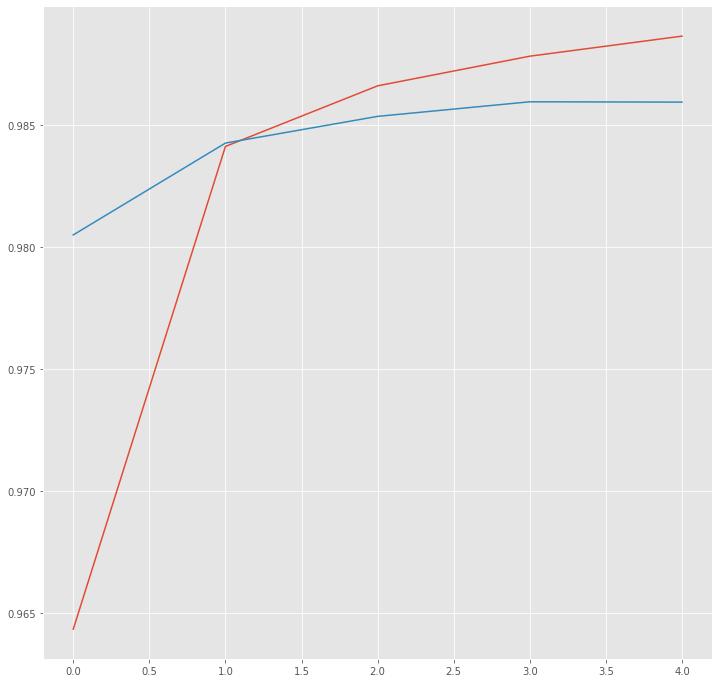

In [94]:
plt.figure(figsize=(12,12))
plt.plot(hist["acc"])
plt.plot(hist["val_acc"])
plt.show()

In [110]:
# Predictions
i = 2318
p = model.predict(np.array([tst_X[i]]))
p = np.argmax(p, axis=-1)
print("{:15} ({:5}): {}".format("Word", "True", "Pred"))

for w, true, pred in zip(tst_X[i], tst_y[i], p[0]):
    t = np.argmax(true, axis=-1)
    print("{:15} ({:5}): {}".format(words[w], tags[t], tags[pred]))

Word            (True ): Pred
In              (O    ): O
a               (O    ): O
separate        (O    ): O
incident        (O    ): O
,               (O    ): O
unknown         (O    ): O
gunmen          (O    ): O
stormed         (O    ): O
a               (O    ): O
house           (O    ): O
in              (O    ): O
western         (B-geo): O
Mosul           (I-geo): B-geo
,               (O    ): O
killing         (O    ): O
a               (O    ): O
woman           (O    ): O
and             (O    ): O
her             (O    ): O
young           (O    ): O
grandchild      (O    ): O
,               (O    ): O
who             (O    ): O
was             (O    ): O
about           (O    ): O
2               (O    ): O
or              (O    ): O
3               (O    ): O
years           (O    ): O
old             (O    ): O
.               (O    ): O
ENDPAD          (O    ): O
ENDPAD          (O    ): O
ENDPAD          (O    ): O
ENDPAD          (O    ): O
ENDPAD          (O   